# Making embeddings from real data

This notebook demonstrates how to make embeddings with the Galileo models using real data (exported by our GEE exporter).

Our GEE exporter is called using the following script:
```python
from datetime import date

from src.data import EarthEngineExporter
from src.data.earthengine import EEBoundingBox

# to export points
EarthEngineExporter(dest_bucket="bucket_name").export_for_latlons(df)
# to export a bounding box
bbox = EEBoundingBox(min_lat=49.017835,min_lon-123.303680,max_lat=49.389519,max_lon-122.792816)
EarthEngineExporter(dest_bucket="bucket_name").export_for_bbox(bbox, start_date=date(2024, 1, 1), end_date=(2025, 1, 1))
```

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import torch 
import numpy as np

from einops import rearrange


from src.galileo import Encoder
from src.data.dataset import DatasetOutput, Normalizer, Dataset
from src.utils import config_dir
from src.data.config import NORMALIZATION_DICT_FILENAME, DATA_FOLDER
from src.masking import MaskedOutput

First, we'll load a dataset output using one of the example training tifs in `data/tifs`. We also normalize it using the same normalization stats we used during training.

In [2]:
normalizing_dict = Dataset.load_normalization_values(
        path=config_dir / NORMALIZATION_DICT_FILENAME
)
normalizer = Normalizer(std=True, normalizing_dicts=normalizing_dict)

dataset_output = Dataset._tif_to_array(
    Path("data/tifs/min_lat=-27.6721_min_lon=25.6796_max_lat=-27.663_max_lon=25.6897_dates=2022-01-01_2023-12-31.tif")
).normalize(normalizer)

dict_keys([13, 16, 6, 18])


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


This tif captures the Vaal river near the [Bloemhof dam](https://en.wikipedia.org/wiki/Bloemhof_Dam). 
We can visualize the S2-RGB bands from the first timestep:

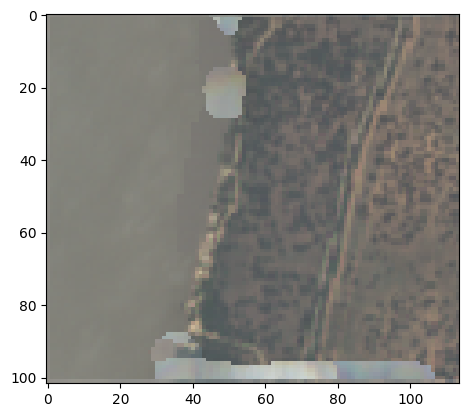

In [3]:
plt.clf()
plt.imshow(dataset_output.space_time_x[:, :, 0, [4, 3, 2]].astype(np.float32))
plt.show()

We'll use the nano model (which is conveniently stored in git) to make these embeddings.

In [4]:
model = Encoder.load_from_folder(DATA_FOLDER / "models/nano")

In [5]:
def make_embeddings(
    model: Encoder,
    datasetoutput: DatasetOutput,
    window_size: int,
    patch_size: int,
    batch_size: int = 128,
    device: torch.device=torch.device("cpu"),
) -> np.ndarray:
    model.eval()
    output_embeddings_list = []
    for i in tqdm(datasetoutput.in_pixel_batches(batch_size=batch_size, window_size=window_size)):
        masked_output = MaskedOutput.from_datasetoutput(i, device=device)
        with torch.no_grad():
            output_embeddings_list.append(model.average_tokens(*model(
                            masked_output.space_time_x.float(),
                            masked_output.space_x.float(),
                            masked_output.time_x.float(),
                            masked_output.static_x.float(),
                            masked_output.space_time_mask,
                            masked_output.space_mask,
                            # lets mask inputs which will be the same for
                            # all pixels in the DatasetOutput
                            torch.ones_like(masked_output.time_mask),
                            torch.ones_like(masked_output.static_mask),
                            masked_output.months.long(),
                            patch_size=patch_size)[:-1]).cpu().numpy())
    output_embeddings = np.concatenate(output_embeddings_list, axis=0)
    # reshape the embeddings to H, W, D
    # first - how many "height batches" and "width batches" did we get?
    h_b = datasetoutput.space_time_x.shape[0] // window_size
    w_b = datasetoutput.space_time_x.shape[1] // window_size
    return rearrange(output_embeddings, "(h_b w_b) d -> h_b w_b d", h_b=h_b, w_b=w_b)

In [ ]:
embeddings = make_embeddings(model, dataset_output, 1, 1, 128)
embeddings_flat = rearrange(embeddings, "h w d -> (h w) d")


91it [00:30,  2.94it/s]


In [ ]:
labels = KMeans(n_clusters=3).fit_predict(embeddings_flat)
labels = rearrange(labels, "(h w) -> h w", h=embeddings.shape[0], w=embeddings.shape[1])

In [ ]:
embeddings_pca = PCA(n_components=3).fit_transform(embeddings_flat)
embeddings_reduced = rearrange(embeddings_pca, "(h w) d -> h w d", h=embeddings.shape[0], w=embeddings.shape[1])

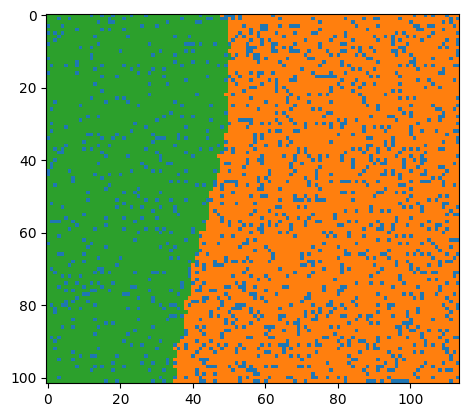

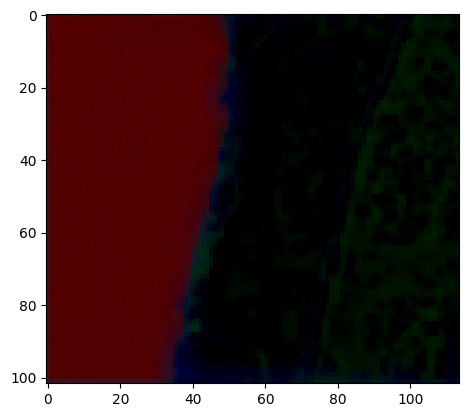

In [9]:
plt.figure()
plt.imshow(labels, cmap='tab10', vmin=0, vmax=9)
plt.show()
plt.close()

plt.figure()
plt.imshow(embeddings_reduced[:,:,0], cmap="bwr", vmin=-1, vmax=1)
plt.show()
plt.close()